# RDKit

RDKit is an open-source cheminformatics library for working with molecules — reading, writing, analyzing, and visualizing them.
SMILES (Simplified Molecular Input Line Entry System) is a text format to represent molecules.
Example:

Water → O

Ethanol → CCO

Benzene → c1ccccc1

In [12]:
# !pip install rdkit
# !pip install py3Dmol

In [103]:
from rdkit import Chem, RDLogger
from rdkit.Chem import ( Draw, Descriptors,
                        AllChem, rdmolfiles,
                        rdMolDescriptors, DataStructs)
from rdkit.Chem.Draw import rdMolDraw2D

import io
from PIL import Image
import py3Dmol

import numpy as np
from contextlib import contextmanager
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Chemical setup

smiles = "C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4"


# Challenge
# Create rdkit molecular object
# Draw the molecule in 2D (Both in Color representation and B&W representation)
# Different representation of benzene
# Control its size

In [17]:
# Making rdkit molecular object

mol_smiles = Chem.MolFromSmiles(smiles)
print(mol_smiles)

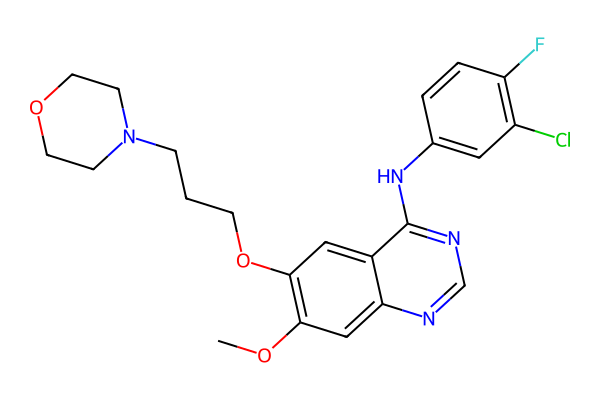

In [19]:
# Plotting the molecular object and controlling the size
Draw.MolToImage(mol_smiles, size = (600, 400))

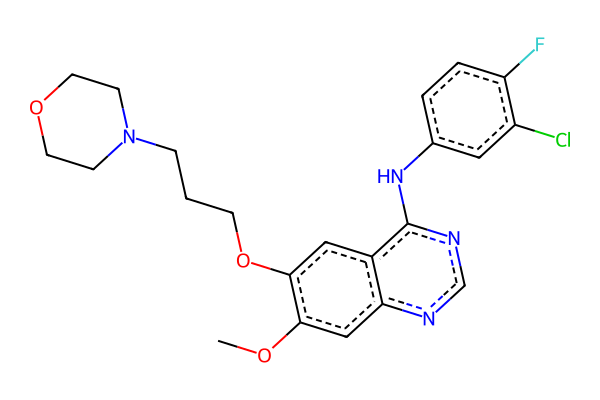

In [20]:
# Kekulisation
Draw.MolToImage(mol_smiles, size=(600, 400), kekulize=False)

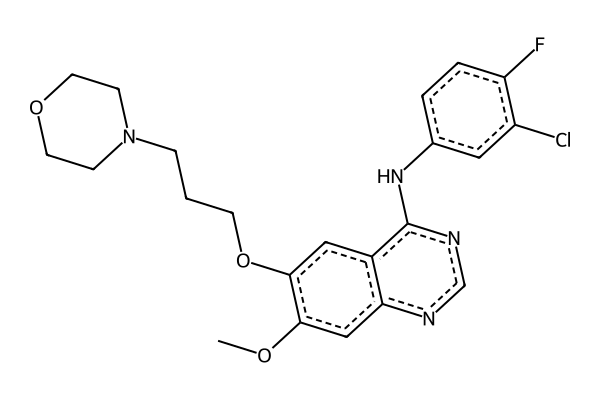

In [25]:
opts = rdMolDraw2D.MolDrawOptions()
opts.useBWAtomPalette()
img = Draw.MolToImage(mol_smiles, size=(600, 400), kekulize=False, options=opts)
img

In [26]:
# Chemical Setup

smiles_list = ["CCO", "CC(=O)O", "C1=CC=CC=C1", "CCN(CC)CC", "CCOC(=O)C"]


# Challenge
# Obtain the molecular object for all of them
# Plot them in a single grid

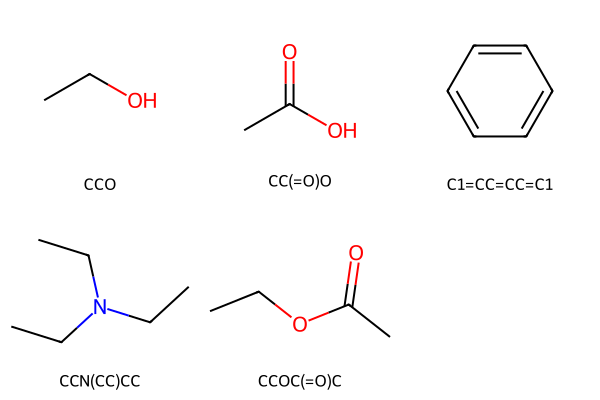

In [34]:
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3,
                     subImgSize=(200, 200),
                     legends=smiles_list)

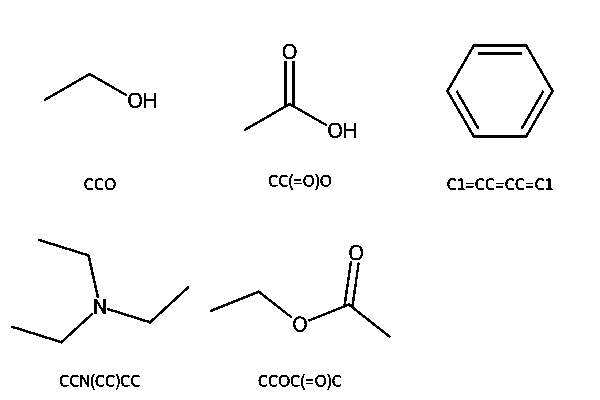

In [31]:
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200),
                           legends=smiles_list)

# If img is an IPython Image, get PNG bytes; otherwise keep as PIL
png_bytes = getattr(img, "data", None) or img._repr_png_()
pil = Image.open(io.BytesIO(png_bytes)) if png_bytes else img  # img is already PIL

bw = pil.convert("L").point(lambda p: 0 if p < 200 else 255).convert("1")
bw

In [46]:
# Chemical Setup

mol = Chem.MolFromSmiles("CCO")  # ethanol

# Challenge
# Calculate molecular object and recover smiles from it
# Calculate its molecular weight, formulae, logP, Hbond d/a

In [48]:
print("SMILES:", Chem.MolToSmiles(mol))
print("Molecular Weight:", Descriptors.MolWt(mol))
print("Molecular Formula:", Chem.rdMolDescriptors.CalcMolFormula(mol))

print("LogP:", Descriptors.MolLogP(mol))
print("Number of H-bond Donors:", Descriptors.NumHDonors(mol))
print("Number of H-bond Acceptors:", Descriptors.NumHAcceptors(mol))

SMILES: CCO
Molecular Weight: 46.069
Molecular Formula: C2H6O
LogP: -0.0014000000000000123
Number of H-bond Donors: 1
Number of H-bond Acceptors: 1


# 3D visualisation of molecules

In [72]:
# Chemical Setup

@contextmanager
def _quiet():
    RDLogger.DisableLog("rdApp.*")
    try:
        yield
    finally:
        RDLogger.EnableLog("rdApp.*")


def smiles_3d_conversion(smiles: str):
    """Embed dot-separated SMILES into 3D and UFF-optimize. Returns list of RDKit molecules."""
    frags = [s for s in smiles.split(".") if s.strip()]
    if not frags:
        raise ValueError("Invalid SMILES string.")
    mols = []
    with _quiet():
        for s in frags:
            m = Chem.MolFromSmiles(s)
            if not m:
                continue
            m = Chem.AddHs(m)
            if AllChem.EmbedMolecule(m, AllChem.ETKDG()) == 0:
                AllChem.UFFOptimizeMolecule(m)
                mols.append(m)
    if not mols:
        raise ValueError("No valid molecules could be embedded.")
    return mols


def molecule_translation(mol: Chem.Mol, translation):
    """Translate all atom coordinates by a 3-vector."""
    t = np.asarray(translation, dtype=float)
    conf = mol.GetConformer()
    for i in range(mol.GetNumAtoms()):
        p = conf.GetAtomPosition(i)
        conf.SetAtomPosition(i, (p.x + t[0], p.y + t[1], p.z + t[2]))
    return mol


def style_preset(name: str, colored: bool = True) -> dict:
    """Return a py3Dmol style dict for setStyle."""
    color_kw = {"colorscheme": "Jmol"} if colored else {"color": "#cccccc"}
    name = name.lower()
    if name in ("ball_and_stick", "ballstick", "ball-stick"):
        return {"stick": {**color_kw}, "sphere": {"scale": 0.25, **color_kw}}
    if name in ("stick", "licorice"):
        return {"stick": {"radius": 0.25, **color_kw}}
    if name in ("line", "wireframe"):
        return {"line": {"linewidth": 2, **color_kw}}
    if name in ("spacefill", "cpk", "sphere"):
        return {"sphere": {"scale": 1.0, **color_kw}}  # 1.0 = VDW radius
    # default
    return {"stick": {**color_kw}}


def mols_3d_visual(smiles: str, is_color: bool,
                   format: str, separation: float = 7.5, ):
    """Return a py3Dmol viewer with spaced molecules and a list of PDB blocks."""
    mols = smiles_3d_conversion(smiles)
    viewer = py3Dmol.view(width=500, height=500)

    with _quiet():
        for i, m in enumerate(mols):
            shift = [i * separation, (i % 2) * separation, (i % 3) * separation]
            molecule_translation(m, shift)
            viewer.addModel(Chem.MolToMolBlock(m), "mol")

    style = style_preset(format, colored = is_color)

    viewer.setStyle(style)
    viewer.setBackgroundColor("#FBFCFC")
    viewer.zoomTo()


    return viewer

# Challenge
# Create 3D image of a given smiles
# Toggle from color to black and white
# Show it in multiple representations - ballstick, stick, wireframe, spacefill
# Translate and rotate the molecules

In [93]:
smiles = 'C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4' # CCO, C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4,
is_color = True
format = "ballstick" # ballstick, stick, wireframe, spacefill
pdb_fig = mols_3d_visual(smiles, is_color, format = format)

In [94]:
pdb_fig.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# **Mini Project** — “Analyze a Small Molecule Library”

Create a DataFrame of SMILES → compute descriptors → visualize.

In [95]:
# Chemical Setup
smiles_list = ["CCO", "CC(=O)O", "c1ccccc1", "CCN(CC)CC", "CNC(=O)O"]

# Challenge
# Calculate molecular formulae
# Calculate molecular weight
# Calculate Topological Polar Surface Area (TPSA)
# Calculate Number of Rings
# Make a dataframe summarising these
# Make a scatter plot TPSA vs mol wt

In [100]:
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

data = []
for s, m in zip(smiles_list, mols):
    data.append({
        "SMILES": s,
        "Formula": Chem.rdMolDescriptors.CalcMolFormula(m),
        "MolWt": Descriptors.MolWt(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "Rings": rdMolDescriptors.CalcNumRings(m)
    })

df = pd.DataFrame(data)
df


,SMILES,Formula,MolWt,TPSA,Rings
0,CCO,C2H6O,46.069,20.23,0
1,CC(=O)O,C2H4O2,60.052,37.30,0
2,c1ccccc1,C6H6,78.114,0.00,1
3,CCN(CC)CC,C6H15N,101.193,3.24,0
4,CNC(=O)O,C2H5NO2,75.067,49.33,0


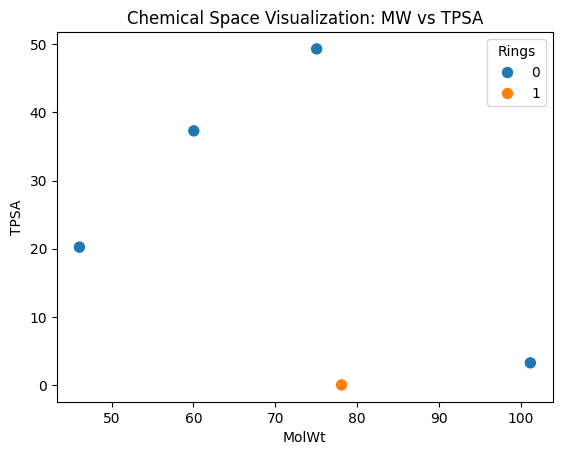

In [102]:
sns.scatterplot(data=df, x="MolWt", y="TPSA", hue="Rings", s=80)
plt.title("Chemical Space Visualization: MW vs TPSA")
plt.show()

In [107]:
# Chemical Setup

RDLogger.DisableLog("rdApp.*")
# Example SMILES list
smiles_list = [
    "CCO",              # ethanol
    "CC(=O)O",          # acetic acid
    "CCCCO",            # butanol
    "c1ccccc1",         # benzene
    "CCN(CC)CC",        # triethylamine
    "CNC(=O)O",         # glycine
]

# Challenge
# Calculate the pair-wise similarity of above molecules
# Summarise it in a dataframe
# Make a heatmap

In [ ]:
# Convert SMILES to mol objects
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

# Compute Morgan fingerprints (circular fingerprints)
# radius = 2 means we consider neighbors up to 2 bonds away
fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024) for m in mols]

# Create a similarity matrix
n = len(fps)
similarity_matrix = [[DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(n)] for i in range(n)]

# Create a pandas DataFrame for visualization
df_sim = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)
df_sim

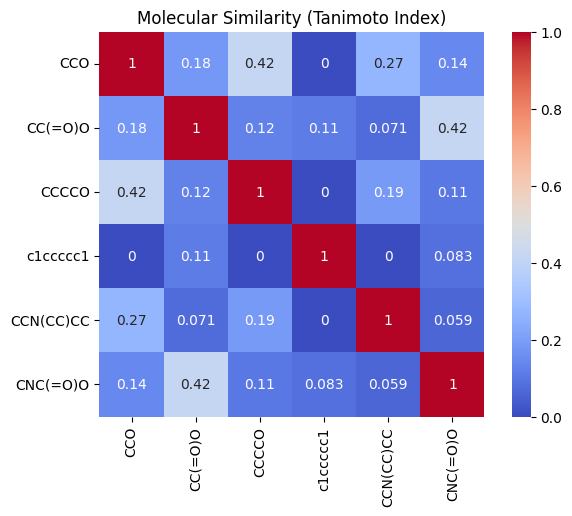

In [106]:
plt.figure(figsize=(7,5))
sns.heatmap(df_sim, annot=True, cmap="coolwarm", square=True)
plt.title("Molecular Similarity (Tanimoto Index)")
plt.show()